In [47]:
import pandas as pd
import numpy as np
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import style
style.use("ggplot")

In [69]:
print('''Brief guide on using ML on a task, Not as much statistical rigor.

Goal: Identify what customers to invest in?


''')

Brief guide on using ML on a task, Not as much statistical rigor.

Goal: Identify what customers to invest in?





In [48]:
url='https://raw.githubusercontent.com/matheusfacure/python-causality-handbook/refs/heads/master/causal-inference-for-the-brave-and-true/data/customer_transactions.csv'
transactions = pd.read_csv(url)

transactions.head()

,customer_id,cacq,day_0,day_1,day_2,day_3,day_4,day_5,day_6,day_7,...,day_20,day_21,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29
0,0,-110,6,0,73,10,0,0,0,21,...,0,0,0,0,0,0,0,0,0,0
1,1,-58,0,0,0,15,0,3,2,0,...,0,0,0,0,0,0,0,0,0,0
2,2,-7,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,3,-30,0,3,2,0,9,0,0,0,...,0,0,40,0,0,0,0,0,0,0
4,4,-42,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [49]:
profitable = (transactions[["customer_id"]]
              .assign(net_value = transactions
                      .drop(columns="customer_id")
                      .sum(axis=1)))

customer_features = (pd.read_csv("https://raw.githubusercontent.com/matheusfacure/python-causality-handbook/refs/heads/master/causal-inference-for-the-brave-and-true/data/customer_features.csv")
                     .merge(profitable, on="customer_id"))

customer_features.head()

,customer_id,region,income,age,net_value
0,0,30,1025,24,130
1,1,41,1649,26,10
2,2,18,2034,33,-6
3,3,20,1859,35,136
4,4,1,1243,26,-8


In [50]:
train, test = train_test_split(customer_features, test_size=0.3, random_state=13)
train.shape, test.shape


((7000, 5), (3000, 5))

In [51]:
train["net_value"].mean()


-29.169428571428572

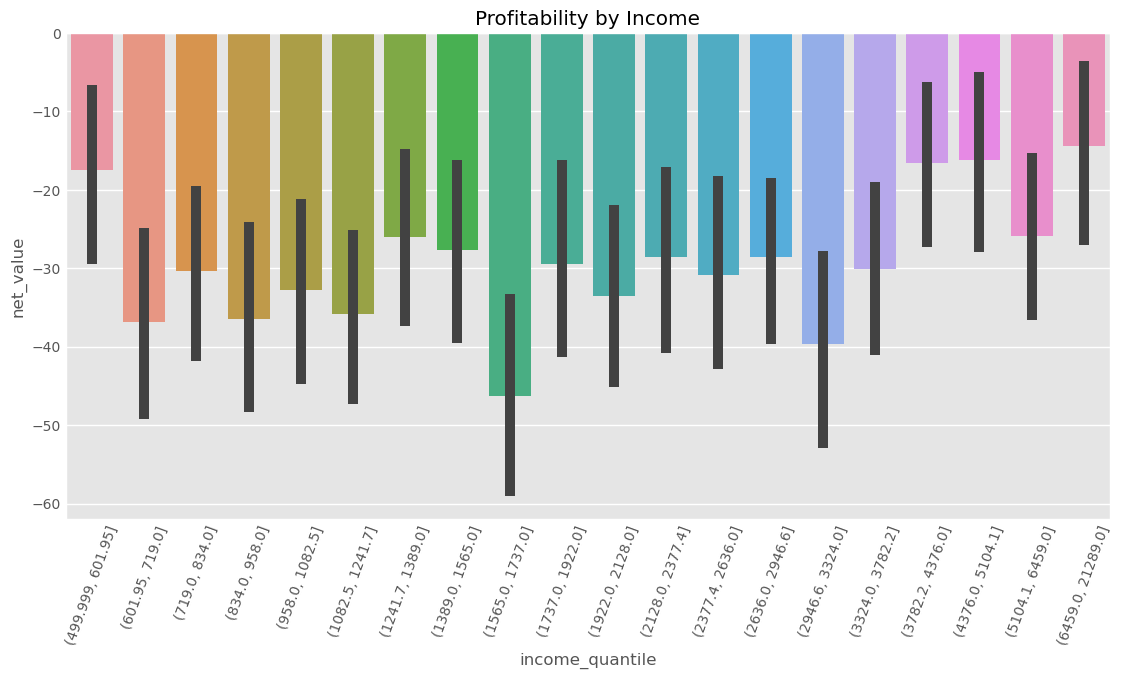

In [52]:
#Rule based, should we just invest in higher income customers?

plt.figure(figsize=(12,6))
np.random.seed(123) ## seed because the CIs from seaborn uses boostrap

# pd.qcut create quantiles of a column
sns.barplot(data=train.assign(income_quantile=pd.qcut(train["income"], q=20)), 
            x="income_quantile", y="net_value")
plt.title("Profitability by Income")
plt.xticks(rotation=70);

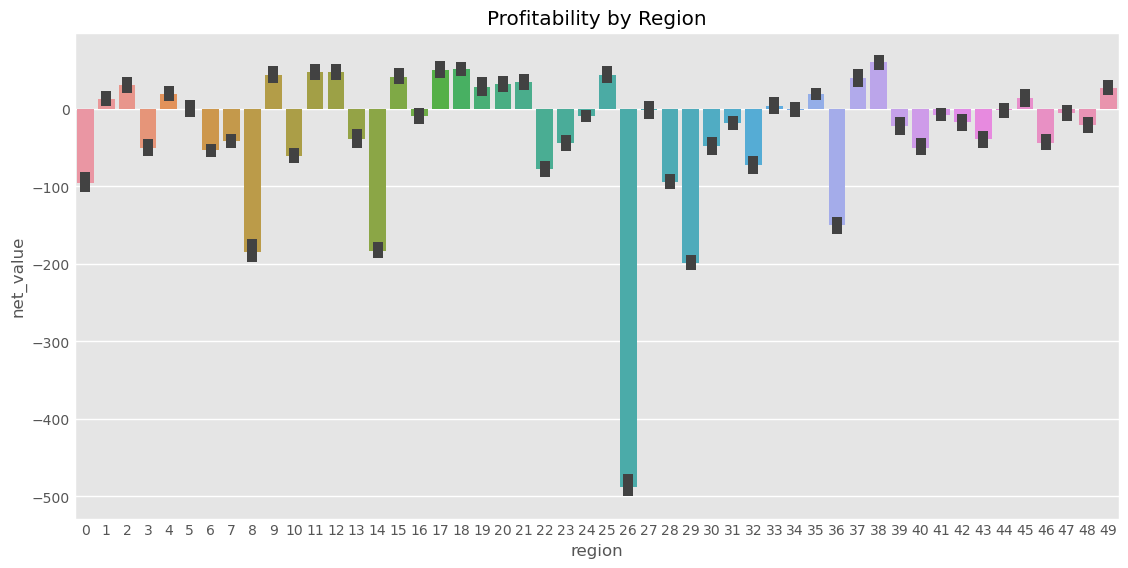

In [53]:
#Rule based, should we just invest based off region?

plt.figure(figsize=(12,6))
np.random.seed(123)
region_plot = sns.barplot(data=train, x="region", y="net_value")
plt.title("Profitability by Region");

In [54]:
# extract the lower bound of the 95% CI from the plot above
regions_to_net = train.groupby('region')['net_value'].agg(['mean', 'count', 'std'])

regions_to_net = regions_to_net.assign(
    lower_bound=regions_to_net['mean'] - 1.96*regions_to_net['std']/(regions_to_net['count']**0.5)
)

regions_to_net_lower_bound = regions_to_net['lower_bound'].to_dict()
regions_to_net = regions_to_net['mean'].to_dict()

# filters regions where the net value lower bound is > 0.
regions_to_invest = {region: net 
                     for region, net in regions_to_net_lower_bound.items()
                     if net > 0}

regions_to_invest

{1: 2.9729729729729737,
 2: 20.543302704837856,
 4: 10.051075065003388,
 9: 32.08862469914759,
 11: 37.434210420891255,
 12: 37.44213667009523,
 15: 32.09847683044394,
 17: 39.52753893574483,
 18: 41.86162250217046,
 19: 15.62406327716401,
 20: 22.06654814414531,
 21: 24.621030401718578,
 25: 33.97022928360584,
 35: 11.68776141117673,
 37: 27.83183541449011,
 38: 49.740709395699994,
 45: 2.286387928016998,
 49: 17.01853709535029}

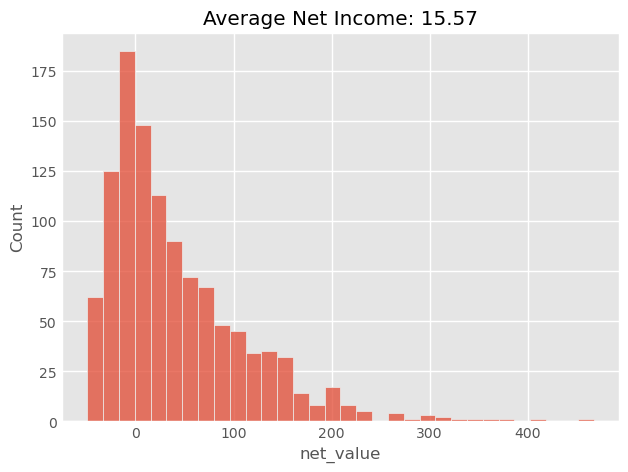

In [70]:
region_policy = (test[test["region"]
                      # filter regions in regions_to_invest
                      .isin(regions_to_invest.keys())]) 

sns.histplot(data=region_policy, x="net_value")
# average has to be over all customers, not just the one we've filtered with the policy
plt.title("Average Net Income: %.2f" % (region_policy["net_value"].sum() / test.shape[0]));

In [56]:
def encode(df): 
    return df.replace({"region": regions_to_net})

In [58]:
#ML Based, 
model_params = {'n_estimators': 400,
                'max_depth': 4,
                'min_samples_split': 10,
                'learning_rate': 0.01,
                'loss': 'squared_error'}

features = ["region", "income", "age"]
target = "net_value"

np.random.seed(123)

reg = ensemble.GradientBoostingRegressor(**model_params)

# fit model on the training set
encoded_train = train[features].pipe(encode)
reg.fit(encoded_train, train[target]);

In [59]:
train_pred = (encoded_train
              .assign(predictions=reg.predict(encoded_train[features])))

print("Train R2: ", r2_score(y_true=train[target], y_pred=train_pred["predictions"]))
print("Test R2: ", r2_score(y_true=test[target], y_pred=reg.predict(test[features].pipe(encode))))

Train R2:  0.7108790300152951
Test R2:  0.6938513063048141


In [60]:
model_policy = test.assign(prediction=reg.predict(test[features].pipe(encode)))

model_policy.head()

,customer_id,region,income,age,net_value,prediction
5952,5952,19,1983,23,21,47.734883
1783,1783,31,914,31,-46,-36.026935
4811,4811,33,1349,25,-19,22.553420
145,145,20,1840,26,55,48.306256
7146,7146,19,3032,34,-17,7.039414


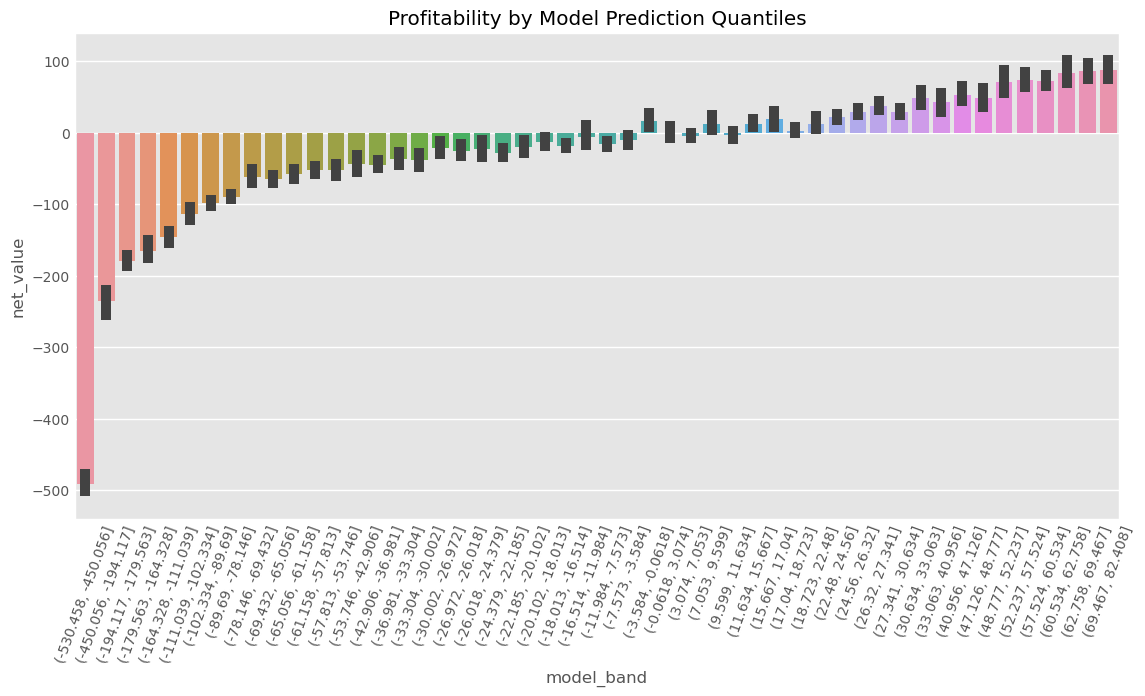

In [62]:
plt.figure(figsize=(12,6))

n_bands = 50
bands = [f"band_{b}" for b in range(1,n_bands+1)]

np.random.seed(123)
model_plot = sns.barplot(data=model_policy
                         .assign(model_band = pd.qcut(model_policy["prediction"], q=n_bands)),
                         x="model_band", y="net_value")
plt.title("Profitability by Model Prediction Quantiles")
plt.xticks(rotation=70);

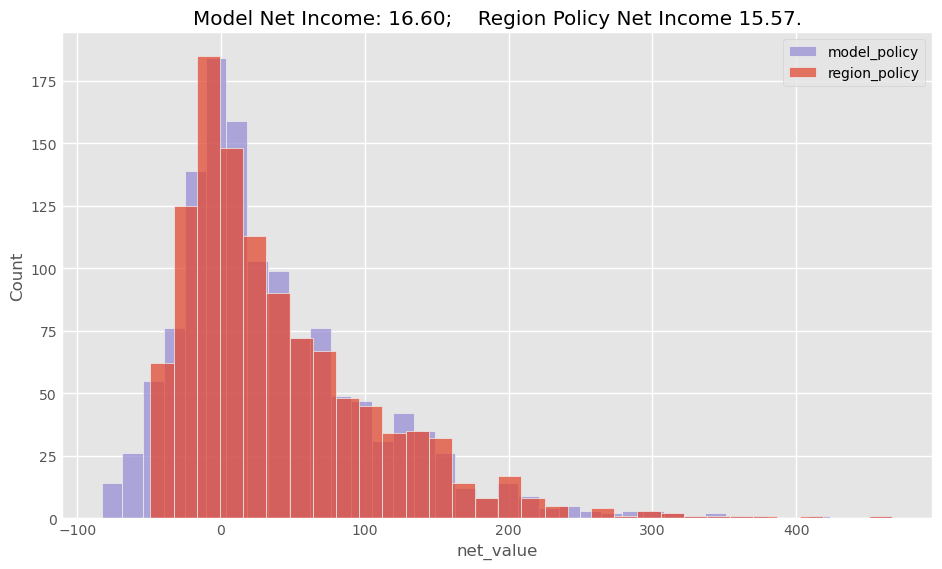

In [63]:
plt.figure(figsize=(10,6))
model_plot_df = (model_policy[model_policy["prediction"]>0])
sns.histplot(data=model_plot_df, x="net_value", color="C2", label="model_policy")

region_plot_df = (model_policy[model_policy["region"].isin(regions_to_invest.keys())])
sns.histplot(data=region_plot_df, x="net_value", label="region_policy")

plt.title("Model Net Income: %.2f;    Region Policy Net Income %.2f." % 
          (model_plot_df["net_value"].sum() / test.shape[0],
           region_plot_df["net_value"].sum() / test.shape[0]))
plt.legend();

In [66]:
def model_binner(prediction_column, bins):
    # find the bins according to the training set
    bands = pd.qcut(prediction_column, q=bins, retbins=True)[1]
    
    def binner_function(prediction_column):
        return np.digitize(prediction_column, bands)
    
    return binner_function
    

# train the binning function
binner_fn = model_binner(train_pred["predictions"], 20)

# apply the binning
model_band = model_policy.assign(bands = binner_fn(model_policy["prediction"]))
model_band.head()

,customer_id,region,income,age,net_value,prediction,bands
5952,5952,19,1983,23,21,47.734883,18
1783,1783,31,914,31,-46,-36.026935,7
4811,4811,33,1349,25,-19,22.553420,15
145,145,20,1840,26,55,48.306256,18
7146,7146,19,3032,34,-17,7.039414,13


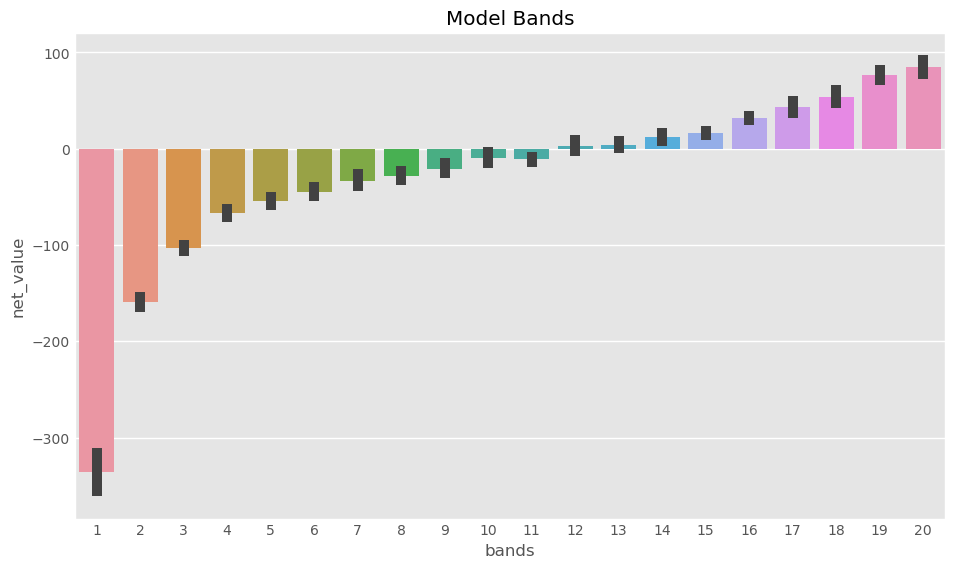

In [67]:
plt.figure(figsize=(10,6))
sns.barplot(data=model_band, x="bands", y="net_value")
plt.title("Model Bands");

In [68]:
mkt_investments_i = model_prediction_i * 0.3


NameError: name 'model_prediction_i' is not defined